In [2]:
import os
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
from skimage import io
from skimage.feature import graycomatrix, graycoprops, hog
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import euclidean
import scipy.ndimage as ndi
import glob
from tqdm import tqdm

In [3]:
class ImageFeatureExtractor:
    """Class for extracting various texture and shape features from images"""
    
    def __init__(self):
        # Parameters for feature extraction
        self.hog_pixels_per_cell = (8, 8)
        self.hog_cells_per_block = (2, 2)
        self.hog_orientations = 9
        self.glcm_distances = [1, 2, 3]
        self.glcm_angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        
        # Gabor filter parameters
        self.gabor_frequencies = [0.05, 0.1, 0.2, 0.3, 0.4]
        self.gabor_orientations = [0, np.pi/6, np.pi/4, np.pi/3, np.pi/2, 2*np.pi/3, 3*np.pi/4, 5*np.pi/6]
        self.gabor_sigma = 3.0
        self.gabor_bandwidth = 1.5
    
    def preprocess_image(self, image, size=(256, 256)):
        """Preprocess image to standardize size and format"""
        # Handle different image formats
        if image is None:
            # Return a blank image if the input is None
            return np.zeros((size[0], size[1], 3), dtype=np.uint8)
            
        if len(image.shape) == 2:  # If grayscale
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        elif image.shape[2] == 4:  # If RGBA
            image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
        
        # Resize image
        image = cv2.resize(image, size)
        return image
    
    def extract_color_texture_features(self, image):
        """Extract BCTU, RCTU and PCTU color texture features"""
        # Convert to different color spaces
        hsv_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        lab_img = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        
        # Extract color channel statistics (mean, std, skewness, kurtosis)
        features = []
        
        # Process each color space
        for img in [image, hsv_img, lab_img]:
            for channel in range(3):
                channel_data = img[:,:,channel].flatten()
                mean = np.mean(channel_data)
                std = np.std(channel_data)
                skewness = np.mean(((channel_data - mean) / std) ** 3) if std > 0 else 0
                kurtosis = np.mean(((channel_data - mean) / std) ** 4) - 3 if std > 0 else 0
                
                features.extend([mean, std, skewness, kurtosis])
        
        return np.array(features)
    
    def extract_gray_texture_features(self, image):
        """Extract BGTU, RGTU, FGTU gray texture features using GLCM"""
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # Calculate GLCM
        glcm = graycomatrix(gray_image, distances=self.glcm_distances, 
                           angles=self.glcm_angles, levels=256, symmetric=True, normed=True)
        
        # Extract GLCM properties
        contrast = graycoprops(glcm, 'contrast').flatten()
        dissimilarity = graycoprops(glcm, 'dissimilarity').flatten()
        homogeneity = graycoprops(glcm, 'homogeneity').flatten()
        energy = graycoprops(glcm, 'energy').flatten()
        correlation = graycoprops(glcm, 'correlation').flatten()
        ASM = graycoprops(glcm, 'ASM').flatten()
        
        # Combine all texture features
        texture_features = np.concatenate([contrast, dissimilarity, homogeneity, 
                                          energy, correlation, ASM])
        
        return texture_features
    
    def gabor_kernel(self, frequency, theta):
        """Create a Gabor filter kernel with specified parameters"""
        sigma_x = self.gabor_sigma
        sigma_y = self.gabor_sigma / self.gabor_bandwidth
        
        # Bounding box
        nstds = 3  # Number of standard deviations
        xmax = max(abs(nstds * sigma_x * np.cos(theta)), abs(nstds * sigma_y * np.sin(theta)))
        xmax = np.ceil(max(1, xmax))
        ymax = max(abs(nstds * sigma_x * np.sin(theta)), abs(nstds * sigma_y * np.cos(theta)))
        ymax = np.ceil(max(1, ymax))
        
        # Create a meshgrid for the kernel
        x, y = np.meshgrid(np.arange(-xmax, xmax + 1), np.arange(-ymax, ymax + 1))
        
        # Rotation
        x_theta = x * np.cos(theta) + y * np.sin(theta)
        y_theta = -x * np.sin(theta) + y * np.cos(theta)
        
        # Calculate Gabor function
        gb = np.exp(-.5 * (x_theta**2 / sigma_x**2 + y_theta**2 / sigma_y**2)) * np.cos(2 * np.pi * frequency * x_theta)
        
        return gb
    
    def extract_gabor_features(self, image):
        """Extract texture features using Gabor filters at multiple scales and orientations"""
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        gray_image = gray_image.astype(np.float32) / 255.0  # Normalize to [0, 1]
        
        gabor_features = []
        
        for frequency in self.gabor_frequencies:
            for theta in self.gabor_orientations:
                # Generate Gabor kernel
                kernel = self.gabor_kernel(frequency, theta)
                
                # Apply filter
                filtered_img = ndi.convolve(gray_image, kernel, mode='wrap')
                
                # Extract statistics from filtered image
                mean = np.mean(filtered_img)
                std = np.std(filtered_img)
                energy = np.sum(filtered_img**2)
                
                gabor_features.extend([mean, std, energy])
        
        return np.array(gabor_features)
    
    def extract_shape_features(self, image):
        """Extract HOG and image moments shape features"""
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # Extract HOG features
        hog_features = hog(gray_image, orientations=self.hog_orientations,
                          pixels_per_cell=self.hog_pixels_per_cell,
                          cells_per_block=self.hog_cells_per_block, visualize=False)
        
        # Calculate image moments
        moments = cv2.moments(gray_image)
        hu_moments = cv2.HuMoments(moments).flatten()
        
        # Log transform Hu moments (common practice since values can be small)
        hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)
        
        # Combine shape features
        shape_features = np.concatenate([hog_features, hu_moments])
        
        return shape_features
    
    def extract_all_features(self, image):
        """Extract all features from an image"""
        processed_image = self.preprocess_image(image)
        
        color_features = self.extract_color_texture_features(processed_image)
        gray_features = self.extract_gray_texture_features(processed_image)
        gabor_features = self.extract_gabor_features(processed_image)
        shape_features = self.extract_shape_features(processed_image)
        
        # Combine all features
        all_features = np.concatenate([color_features, gray_features, gabor_features, shape_features])
        
        return all_features

In [4]:
class PSOOptimizer:
    """Particle Swarm Optimization for feature weight optimization"""
    
    def __init__(self, n_dimensions, n_particles=30, max_iter=50):
        self.n_dimensions = n_dimensions
        self.n_particles = n_particles
        self.max_iter = max_iter
        
        # PSO parameters
        self.w = 0.7  # Inertia weight
        self.c1 = 1.5  # Cognitive weight
        self.c2 = 1.5  # Social weight
        
        # Initialize particles and velocities
        self.particles = np.random.uniform(0, 1, (self.n_particles, self.n_dimensions))
        self.velocities = np.zeros((self.n_particles, self.n_dimensions))
        
        # Normalize weights to sum to 1
        self.particles = self.particles / np.sum(self.particles, axis=1)[:, np.newaxis]
        
        # Initialize best positions
        self.pbest = self.particles.copy()
        self.pbest_fitness = np.zeros(self.n_particles) + np.inf
        self.gbest = None
        self.gbest_fitness = np.inf
    
    def optimize(self, fitness_function):
        """Run PSO optimization"""
        for iteration in range(self.max_iter):
            # Evaluate fitness for each particle
            for i in range(self.n_particles):
                fitness = fitness_function(self.particles[i])
                
                # Update personal best
                if fitness < self.pbest_fitness[i]:
                    self.pbest_fitness[i] = fitness
                    self.pbest[i] = self.particles[i].copy()
                
                # Update global best
                if fitness < self.gbest_fitness:
                    self.gbest_fitness = fitness
                    self.gbest = self.particles[i].copy()
            
            # Update velocities and positions
            for i in range(self.n_particles):
                r1, r2 = np.random.random(2)
                self.velocities[i] = (self.w * self.velocities[i] +
                                    self.c1 * r1 * (self.pbest[i] - self.particles[i]) +
                                    self.c2 * r2 * (self.gbest - self.particles[i]))
                
                self.particles[i] += self.velocities[i]
                
                # Ensure weights are non-negative
                self.particles[i] = np.maximum(0, self.particles[i])
                
                # Normalize weights to sum to 1
                if np.sum(self.particles[i]) > 0:
                    self.particles[i] = self.particles[i] / np.sum(self.particles[i])
            
            # Print progress
            if (iteration + 1) % 10 == 0:
                print(f"Iteration {iteration + 1}/{self.max_iter}, Best fitness: {self.gbest_fitness:.6f}")
                
        return self.gbest, self.gbest_fitness

In [5]:
class CBIR_Corel:
    """Implementation of CBIR system for Corel dataset"""
    
    def __init__(self):
        self.feature_extractor = ImageFeatureExtractor()
        self.rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        self.feature_weights = None
        self.categories = None
    
    def load_corel_dataset(self, dataset_path, subset='training_set', limit_per_category=None):
        """Load images from Corel dataset directory structure"""
        images = []
        labels = []
        image_paths = []
        categories = []
        
        subset_path = os.path.join(dataset_path, subset)
        if not os.path.exists(subset_path):
            raise ValueError(f"Dataset subset path {subset_path} does not exist")
        
        # Get all category folders
        category_folders = sorted([d for d in os.listdir(subset_path) 
                                  if os.path.isdir(os.path.join(subset_path, d))])
        
        print(f"Found {len(category_folders)} categories in {subset_path}")
        self.categories = category_folders
        
        for category_idx, category in enumerate(category_folders):
            category_path = os.path.join(subset_path, category)
            image_files = glob.glob(os.path.join(category_path, "*.jpg")) + \
                         glob.glob(os.path.join(category_path, "*.jpeg")) + \
                         glob.glob(os.path.join(category_path, "*.png"))
            
            # Limit the number of images per category if specified
            if limit_per_category:
                image_files = image_files[:limit_per_category]
            
            print(f"Loading {len(image_files)} images from category '{category}'")
            
            for img_path in tqdm(image_files):
                try:
                    # Load image
                    image = io.imread(img_path)
                    
                    # Store image, label, and path
                    images.append(image)
                    labels.append(category_idx)  # Use category index as label
                    image_paths.append(img_path)
                    categories.append(category)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
        
        return images, labels, image_paths, categories
    
    def extract_features_from_dataset(self, images):
        """Extract features from all images in the dataset"""
        all_features = []
        
        for i, image in enumerate(tqdm(images, desc="Extracting features")):
            features = self.feature_extractor.extract_all_features(image)
            all_features.append(features)
        
        return np.array(all_features)
    
    def train_rf_classifier(self, features, labels):
        """Train the Random Forest classifier"""
        X_train, X_test, y_train, y_test = train_test_split(
            features, labels, test_size=0.2, random_state=42
        )
        
        print("Training Random Forest classifier...")
        self.rf_classifier.fit(X_train, y_train)
        
        # Evaluate classifier
        y_pred = self.rf_classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"RF Classifier Accuracy: {accuracy:.4f}")

        # Calculate feature importances from RF
        feature_importances = self.rf_classifier.feature_importances_
        return feature_importances
    
    def optimize_weights_with_pso(self, features, labels):
        """Optimize feature weights using PSO"""
        print("Starting PSO optimization...")
        # Group features by class
        unique_labels = np.unique(labels)
        class_features = {label: [] for label in unique_labels}
        
        for i, label in enumerate(labels):
            class_features[label].append(features[i])
        
        # Convert lists to arrays
        for label in unique_labels:
            class_features[label] = np.array(class_features[label])
        
        # Calculate class means
        class_means = {label: np.mean(class_features[label], axis=0) for label in unique_labels}
        
        # Calculate overall mean
        overall_mean = np.mean(features, axis=0)
        
        # Define fitness function for PSO (minimize within-class scatter / between-class scatter)
        def fitness_function(weights):
            # Apply weights to features
            weighted_class_means = {label: weights * class_means[label] for label in unique_labels}
            weighted_overall_mean = weights * overall_mean
            
            # Calculate between-class scatter
            between_scatter = 0
            for label in unique_labels:
                diff = weighted_class_means[label] - weighted_overall_mean
                between_scatter += len(class_features[label]) * np.sum(diff**2)
            
            # Calculate within-class scatter
            within_scatter = 0
            for label in unique_labels:
                for feature in class_features[label]:
                    weighted_feature = weights * feature
                    diff = weighted_feature - weighted_class_means[label]
                    within_scatter += np.sum(diff**2)
            
            # Avoid division by zero
            if between_scatter == 0:
                return np.inf
            
            # Return ratio (minimize within / between)
            return within_scatter / between_scatter
        
        # Initialize PSO
        pso = PSOOptimizer(n_dimensions=features.shape[1], n_particles=20, max_iter=50)
        
        # Run optimization
        best_weights, best_fitness = pso.optimize(fitness_function)
        
        self.feature_weights = best_weights
        return best_weights
    
    def calculate_weighted_distance(self, query_features, database_features):
        """Calculate weighted Euclidean distance between query and database features"""
        distances = []
        
        for db_feature in database_features:
            # Apply feature weights
            weighted_query = self.feature_weights * query_features
            weighted_db = self.feature_weights * db_feature
            
            # Calculate Euclidean distance
            dist = euclidean(weighted_query, weighted_db)
            distances.append(dist)
        
        return np.array(distances)
    
    def predict_category(self, query_features):
        """Predict category using trained RF classifier"""
        if self.rf_classifier is None:
            raise ValueError("RF classifier is not trained yet")
        
        predicted_class = self.rf_classifier.predict([query_features])[0]
        return predicted_class
    
    def retrieve_similar_images(self, query_image, top_k=10):
        """Retrieve top-k similar images using weighted distance"""
        # Extract features from query image
        query_features = self.feature_extractor.extract_all_features(query_image)
        
        # Calculate distances
        distances = self.calculate_weighted_distance(query_features, self.database_features)
        
        # Get indices of top-k similar images
        top_indices = np.argsort(distances)[:top_k]
        
        # Return paths, categories, and distances of similar images
        similar_images = [self.database_paths[i] for i in top_indices]
        similar_categories = [self.database_categories[i] for i in top_indices]
        similar_distances = distances[top_indices]
        
        # Predict category of query image
        predicted_class = self.predict_category(query_features)
        predicted_category = self.categories[predicted_class] if self.categories else str(predicted_class)
        
        return similar_images, similar_categories, similar_distances, predicted_category
    
    def train(self, dataset_path, limit_per_category=None):
        """Train the CBIR model on Corel dataset"""
        print("Loading training dataset...")
        images, labels, image_paths, categories = self.load_corel_dataset(
            dataset_path, subset='training_set', limit_per_category=limit_per_category
        )
        
        print(f"Loaded {len(images)} images from {len(np.unique(labels))} categories")
        
        print("Extracting features from training images...")
        features = self.extract_features_from_dataset(images)
        
        print("Training RF classifier...")
        feature_importances = self.train_rf_classifier(features, labels)
        
        print("Optimizing feature weights with PSO...")
        self.optimize_weights_with_pso(features, labels)
        
        # Store database features and paths for later retrieval
        self.database_features = features
        self.database_paths = image_paths
        self.database_labels = labels
        self.database_categories = categories
        
        print("Training complete!")
        return features, labels, image_paths
    
    def evaluate(self, dataset_path, limit_per_category=None):
        """Evaluate the CBIR model on test dataset"""
        print("Loading test dataset...")
        test_images, test_labels, test_paths, test_categories = self.load_corel_dataset(
            dataset_path, subset='test_set', limit_per_category=limit_per_category
        )
        
        print(f"Loaded {len(test_images)} test images from {len(np.unique(test_labels))} categories")
        
        # Calculate accuracy metrics
        correct_predictions = 0
        top_5_correct = 0
        
        for i, (image, true_label) in enumerate(zip(test_images, test_labels)):
            if i % 10 == 0:
                print(f"Evaluating image {i+1}/{len(test_images)}")
            
            # Query the system
            similar_images, similar_categories, _, predicted_category = self.retrieve_similar_images(image, top_k=5)
            
            # Get true category
            true_category = self.categories[true_label]
            
            # Check if top prediction is correct
            if predicted_category == true_category:
                correct_predictions += 1
            
            # Check if true category is in top 5
            if true_category in similar_categories:
                top_5_correct += 1
        
        # Calculate metrics
        accuracy = correct_predictions / len(test_images)
        top_5_accuracy = top_5_correct / len(test_images)
        
        print(f"Evaluation results:")
        print(f"Top-1 Accuracy: {accuracy:.4f}")
        print(f"Top-5 Accuracy: {top_5_accuracy:.4f}")
        
        return accuracy, top_5_accuracy
    
    def query(self, query_image_path, top_k=10):
        """Query the system with a new image"""
        query_image = io.imread(query_image_path)
        
        similar_images, similar_categories, distances, predicted_category = self.retrieve_similar_images(
            query_image, top_k=top_k
        )
        
        return similar_images, similar_categories, distances, predicted_category
    
    def save_model(self, model_path):
        """Save the trained model for later use"""
        model_data = {
            'feature_weights': self.feature_weights,
            'database_features': self.database_features,
            'database_paths': self.database_paths,
            'database_labels': self.database_labels,
            'database_categories': self.database_categories,
            'rf_classifier': self.rf_classifier,
            'categories': self.categories
        }
        
        with open(model_path, 'wb') as f:
            pickle.dump(model_data, f)
        
        print(f"Model saved to {model_path}")
    
    def load_model(self, model_path):
        """Load a previously trained model"""
        try:
            with open(model_path, 'rb') as f:
                model_data = pickle.load(f)
            
            self.feature_weights = model_data['feature_weights']
            self.database_features = model_data['database_features']
            self.database_paths = model_data['database_paths']
            self.database_labels = model_data['database_labels']
            self.database_categories = model_data.get('database_categories', [])
            self.rf_classifier = model_data['rf_classifier']
            self.categories = model_data.get('categories', [])
            
            print(f"Model loaded from {model_path}")
            return True
        except Exception as e:
            print(f"Error loading model: {e}")
            return False
    
    def visualize_results(self, query_image_path, similar_images, similar_categories, distances):
        """Visualize query results"""
        query_image = io.imread(query_image_path)
        
        # Determine the number of rows and columns for the plot
        n_results = len(similar_images)
        n_cols = 3
        n_rows = (n_results // n_cols) + 2  # Extra row for query image and predicted category
        
        plt.figure(figsize=(15, n_rows * 5))
        
        # Display query image
        plt.subplot(n_rows, n_cols, 1)
        plt.imshow(query_image)
        plt.title("Query Image")
        plt.axis('off')
        
        # Display similar images
        for i, (img_path, category, dist) in enumerate(zip(similar_images, similar_categories, distances)):
            img = io.imread(img_path)
            plt.subplot(n_rows, n_cols, i + n_cols + 1)
            plt.imshow(img)
            plt.title(f"Rank {i+1}: {category}\nDistance: {dist:.4f}")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def visualize_feature_importance(self):
        """Visualize feature importance from Random Forest classifier"""
        if not hasattr(self.rf_classifier, 'feature_importances_'):
            print("Random Forest classifier not trained yet.")
            return
            
        feature_types = [
            ("Color (RGB, HSV, LAB)", 36),  # 3 spaces × 3 channels × 4 stats
            ("GLCM Texture", 72),           # 6 properties × 3 distances × 4 angles
            ("Gabor Texture", len(self.feature_extractor.gabor_frequencies) * 
                             len(self.feature_extractor.gabor_orientations) * 3),  # 5 freq × 8 orient × 3 stats
            ("Shape (HOG + Moments)", 7 + self.feature_extractor.hog_orientations * 
                                        (self.feature_extractor.hog_pixels_per_cell[0] * 
                                        self.feature_extractor.hog_pixels_per_cell[1]) * 
                                        (self.feature_extractor.hog_cells_per_block[0] * 
                                        self.feature_extractor.hog_cells_per_block[1]))
        ]
        
        importances = self.rf_classifier.feature_importances_
        
        # Group importances by feature type
        feature_group_importances = []
        start_idx = 0
        
        for name, size in feature_types:
            group_importance = np.sum(importances[start_idx:start_idx + size])
            feature_group_importances.append((name, group_importance))
            start_idx += size
        
        # Sort by importance
        feature_group_importances.sort(key=lambda x: x[1], reverse=True)
        
        # Plot
        plt.figure(figsize=(10, 6))
        names = [x[0] for x in feature_group_importances]
        values = [x[1] for x in feature_group_importances]
        
        plt.bar(names, values)
        plt.title('Feature Group Importance')
        plt.ylabel('Importance')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

Loading existing model from corel_cbir_model.pkl
Model loaded from corel_cbir_model.pkl
Loading test dataset...
Found 10 categories in CBIR_1K/dataset/test_set
Loading 10 images from category 'beaches'


100%|██████████| 10/10 [00:00<00:00, 1030.97it/s]


Loading 10 images from category 'bus'


100%|██████████| 10/10 [00:00<00:00, 1102.69it/s]


Loading 10 images from category 'dinosaurs'


100%|██████████| 10/10 [00:00<00:00, 1287.50it/s]


Loading 10 images from category 'elephants'


100%|██████████| 10/10 [00:00<00:00, 1041.93it/s]


Loading 10 images from category 'flowers'


100%|██████████| 10/10 [00:00<00:00, 1229.03it/s]


Loading 10 images from category 'foods'


100%|██████████| 10/10 [00:00<00:00, 1099.48it/s]


Loading 10 images from category 'horses'


100%|██████████| 10/10 [00:00<00:00, 996.25it/s]


Loading 10 images from category 'monuments'


100%|██████████| 10/10 [00:00<00:00, 950.94it/s]


Loading 10 images from category 'mountains_and_snow'


100%|██████████| 10/10 [00:00<00:00, 1010.04it/s]


Loading 10 images from category 'peolpe_and_villages_in_Africa'


100%|██████████| 10/10 [00:00<00:00, 970.03it/s]


Loaded 100 test images from 10 categories
Evaluating image 1/100
Evaluating image 11/100
Evaluating image 21/100
Evaluating image 31/100
Evaluating image 41/100
Evaluating image 51/100
Evaluating image 61/100
Evaluating image 71/100
Evaluating image 81/100
Evaluating image 91/100
Evaluation results:
Top-1 Accuracy: 0.7400
Top-5 Accuracy: 0.6000
Test set evaluation - Accuracy: 0.7400, Top-5 Accuracy: 0.6000


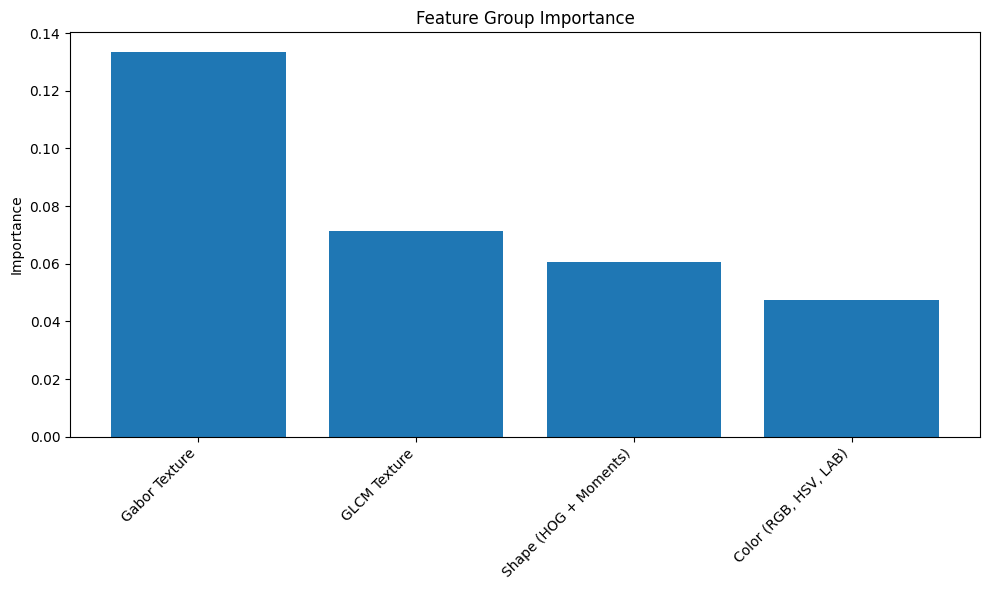

Automatically selected query image: CBIR_1K/dataset/test_set/peolpe_and_villages_in_Africa/5.jpg
Query image predicted category: peolpe_and_villages_in_Africa


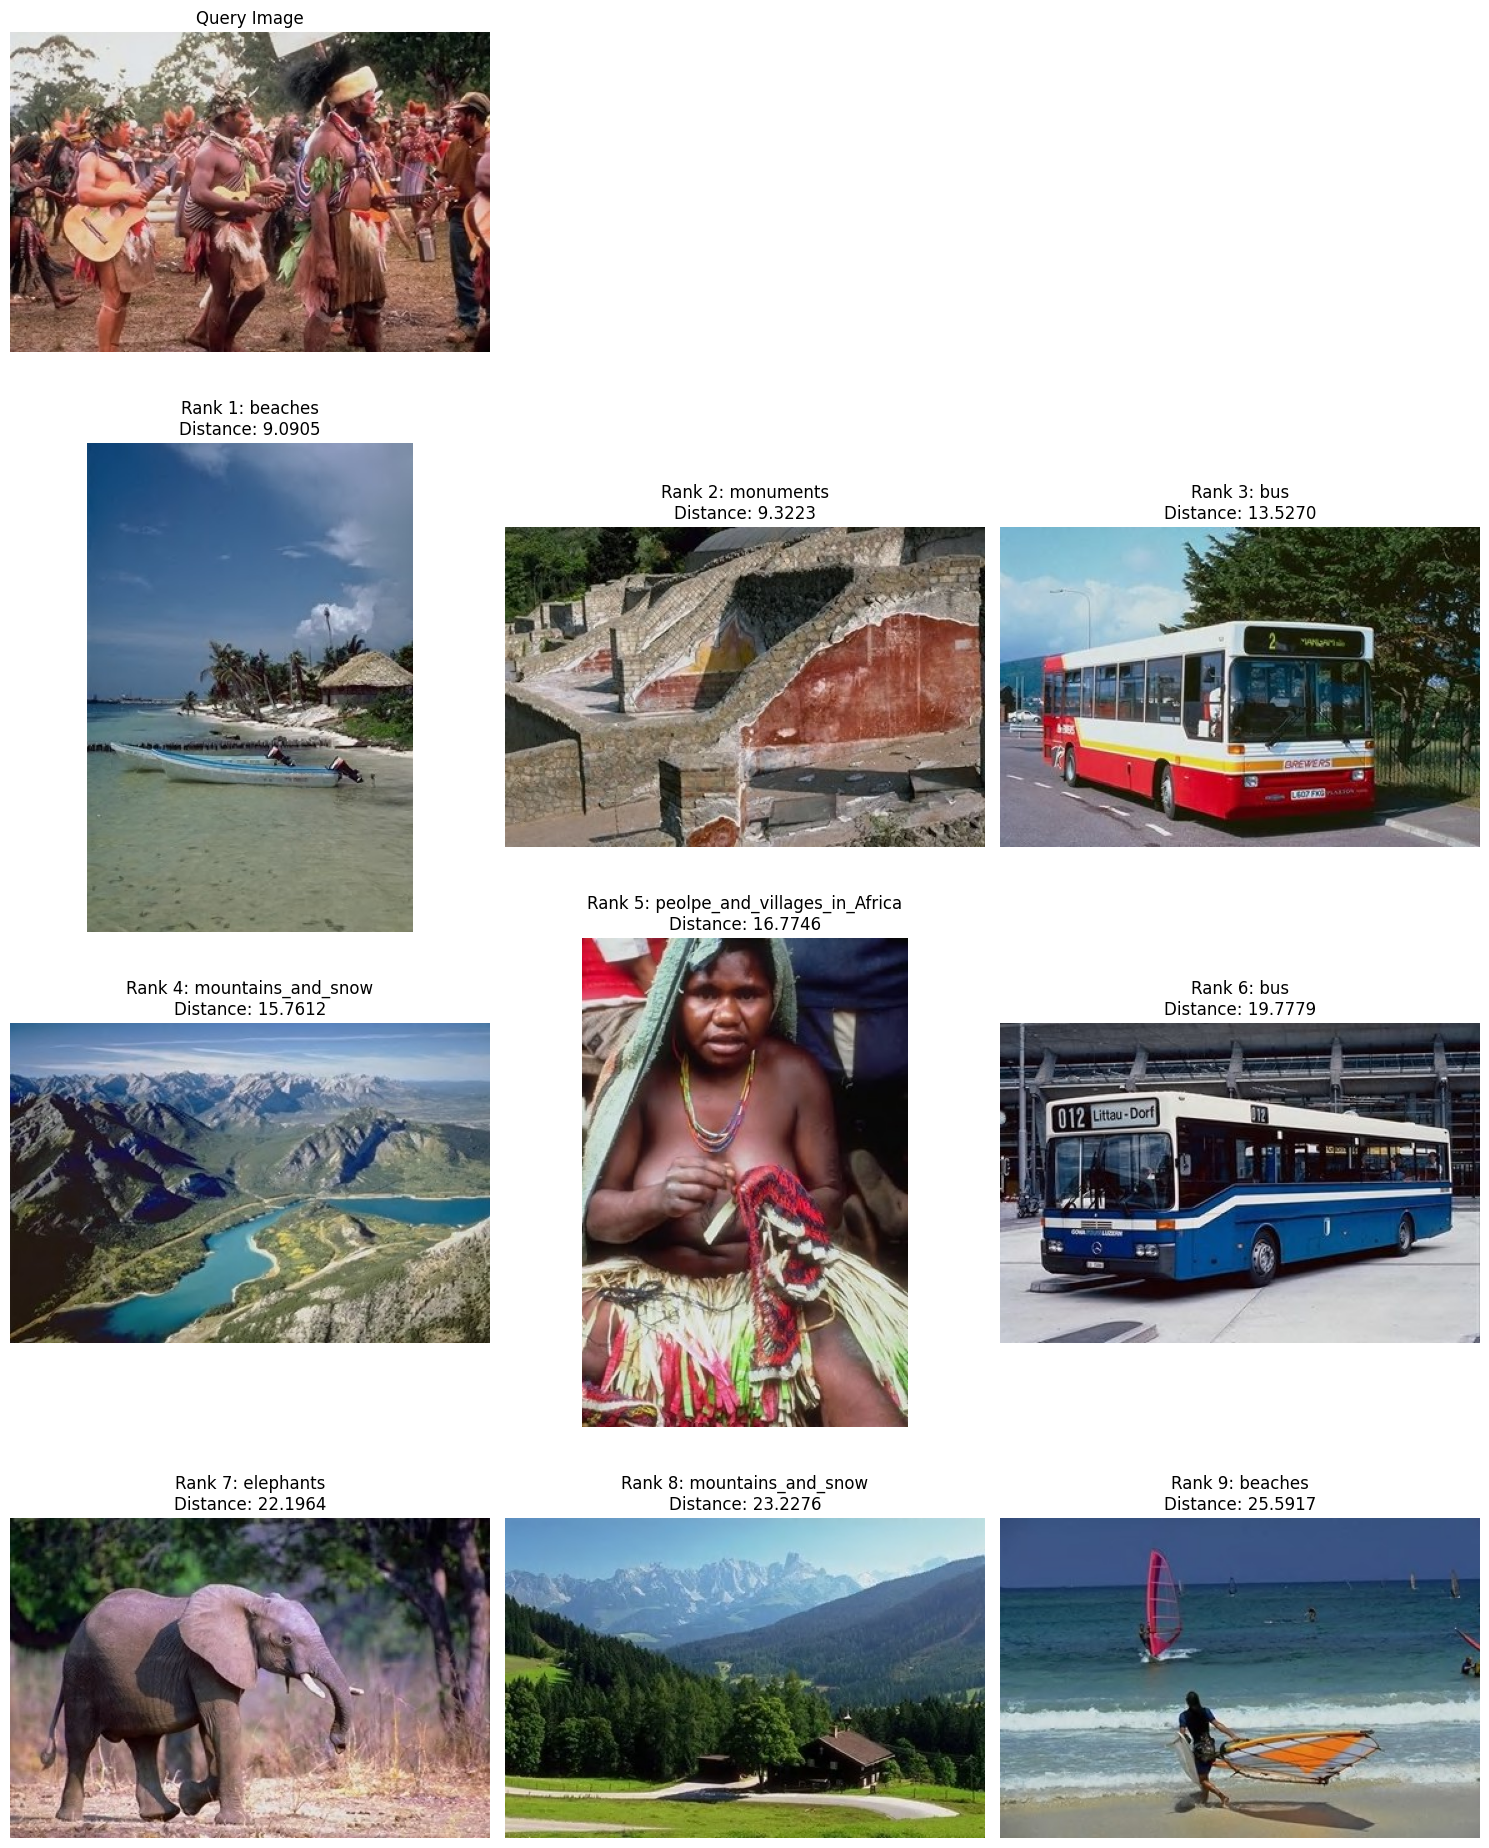

In [9]:
if __name__ == "__main__":
    # Initialize the CBIR system
    cbir = CBIR_Corel()
    
    # Path to dataset
    dataset_path = "CBIR_1K/dataset"
    
    # Train or load model
    model_path = "corel_cbir_model.pkl"
    
    if os.path.exists(model_path):
        print(f"Loading existing model from {model_path}")
        cbir.load_model(model_path)
    else:
        print(f"Training new model using data from {dataset_path}")
        # Train with a limit of 100 images per category (adjust as needed)
        cbir.train(dataset_path, limit_per_category=100)
        cbir.save_model(model_path)
    
    # Evaluate on test set
    accuracy, top5_accuracy = cbir.evaluate(dataset_path, limit_per_category=50)
    print(f"Test set evaluation - Accuracy: {accuracy:.4f}, Top-5 Accuracy: {top5_accuracy:.4f}")
    
    # Visualize feature importance
    cbir.visualize_feature_importance()
    
    # Example query
    # Change this to a path from your test set
    query_path = os.path.join(dataset_path, "test_set", "beaches", "300.jpg")
    
    # If you don't have a specific path, find one automatically
    if not os.path.exists(query_path):
        test_folders = os.path.join(dataset_path, "test_set")
        categories = [f for f in os.listdir(test_folders) if os.path.isdir(os.path.join(test_folders, f))]
        if categories:
            category = categories[0]
            image_files = glob.glob(os.path.join(test_folders, category, "*.jpg"))
            if image_files:
                query_path = image_files[0]
                print(f"Automatically selected query image: {query_path}")
    
    if os.path.exists(query_path):
        similar_images, similar_categories, distances, predicted_category = cbir.query(query_path, top_k=9)
        print(f"Query image predicted category: {predicted_category}")
        cbir.visualize_results(query_path, similar_images, similar_categories, distances)
    else:
        print("Please specify a valid query image path.")